In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
import numpy as np
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import math
import geopandas as gpd
from shapely.geometry import box
import os

### Inputs

In [2]:
# -------------------------------
# Load data
skill_scores_long = pd.read_csv('./camels-spat/full_bm_skill_scores/nse_full_skill_scores.csv')
output_dir = './camels-spat/full_bm_skill_scores/nse_plots/'
plot_prefix = 'nse'

# -------------------------------
# Settings
period = 'validation'

border_path = './camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'

In [3]:
# Specify the benchmarks and metrics to calculate
map_plots = [
    # Streamflow benchmarks
    "bm_mean_flow",
    # "bm_median_flow",
    # # # "bm_annual_mean_flow",  NaN
    # # # "bm_annual_median_flow",  NaN
    # # "bm_monthly_mean_flow",
    # # "bm_monthly_median_flow",
    "bm_daily_mean_flow",
    # # "bm_daily_median_flow",

    # # Long-term rainfall-runoff ratio benchmarks
    # "bm_rainfall_runoff_ratio_to_all",
    # "bm_rainfall_runoff_ratio_to_annual",
    # "bm_rainfall_runoff_ratio_to_monthly",
     "bm_rainfall_runoff_ratio_to_daily",
    # "bm_rainfall_runoff_ratio_to_timestep",

    # # Short-term rainfall-runoff ratio benchmarks
    # "bm_monthly_rainfall_runoff_ratio_to_monthly",
    # "bm_monthly_rainfall_runoff_ratio_to_daily",
    # "bm_monthly_rainfall_runoff_ratio_to_timestep",

    # # Schaefli & Gupta (2007) benchmarks
    # "bm_scaled_precipitation_benchmark",  # equivalent to "rainfall_runoff_ratio_to_daily"
    # "bm_adjusted_precipitation_benchmark",
     "bm_adjusted_smoothed_precipitation_benchmark",

    # # Summary 
     'highest',
     'lowest'
      ]

difference_plots= [
    # Streamflow benchmarks
    "bm_mean_flow",
    'difference'
]

# Specify the benchmarks and metrics to calculate
cdf_plots = [
    # Streamflow benchmarks
    "bm_mean_flow",
    "bm_median_flow",
    # "bm_annual_mean_flow",  NaN
    # "bm_annual_median_flow",  NaN
    "bm_monthly_mean_flow",
    "bm_monthly_median_flow",
    "bm_daily_mean_flow",
    "bm_daily_median_flow",

    # Long-term rainfall-runoff ratio benchmarks
    "bm_rainfall_runoff_ratio_to_all",
    "bm_rainfall_runoff_ratio_to_annual",
    "bm_rainfall_runoff_ratio_to_monthly",
     "bm_rainfall_runoff_ratio_to_daily",
    "bm_rainfall_runoff_ratio_to_timestep",

    # Short-term rainfall-runoff ratio benchmarks
    "bm_monthly_rainfall_runoff_ratio_to_monthly",
    "bm_monthly_rainfall_runoff_ratio_to_daily",
    "bm_monthly_rainfall_runoff_ratio_to_timestep",

    # Schaefli & Gupta (2007) benchmarks
    "bm_scaled_precipitation_benchmark",  # equivalent to "rainfall_runoff_ratio_to_daily"
    "bm_adjusted_precipitation_benchmark",
    "bm_adjusted_smoothed_precipitation_benchmark",

    # Summary 
    'highest',
    'lowest'
     ]

### Pre-Processing

In [4]:
# Filter by period
df_period = skill_scores_long[skill_scores_long['period'] == period]

# Function to get value + corresponding benchmark
def get_extreme(df, agg_func='max'):
    if agg_func == 'max':
        idx = df['skill_score'].idxmax()
    else:
        idx = df['skill_score'].idxmin()
    return pd.Series({
        'value': df.loc[idx, 'skill_score'],
        'benchmark': df.loc[idx, 'benchmark']
    })

# Compute highest and lowest per catchment
catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(
    lambda x: pd.concat([
        get_extreme(x, 'max').rename(lambda k: f'highest_{k}'),
        get_extreme(x, 'min').rename(lambda k: f'lowest_{k}')
    ])
).reset_index()

# Merge lat/lon
latlon = df_period[['catchment','latitude','longitude']].drop_duplicates()
catchment_stats = catchment_extremes.merge(latlon, on='catchment', how='left')

/tmp/ipykernel_145357/873659307.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(


In [5]:
# --- Load borders shapefile once
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    
    # Reproject to EPSG:4326 if needed
    if gdf_borders.crs != "EPSG:4326":
        gdf_borders = gdf_borders.to_crs("EPSG:4326")
    
    map_color = '0.65'

### Spatial Plots

In [6]:
# # Prepare data for plotting
# plot_dfs = {}
# for benchmark in map_plots:
#     if benchmark == 'highest':
#         plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']].rename(columns={'highest_value':'skill_score'})
#     elif benchmark == 'lowest':
#         plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']].rename(columns={'lowest_value':'skill_score'})
#     else:
#         plot_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][['catchment','latitude','longitude','skill_score']]

# Prepare data for plotting
plot_dfs = {}

for benchmark in map_plots:
    if benchmark == 'highest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']]\
            .rename(columns={'highest_value':'skill_score'})
    
    elif benchmark == 'lowest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']]\
            .rename(columns={'lowest_value':'skill_score'})
    
    elif benchmark == 'difference':
        # Extract mean_flow rows
        df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
            'catchment', 'latitude', 'longitude', 'skill_score'
        ]].rename(columns={'skill_score': 'mean_flow_score'})
        
        # Extract lowest values from catchment_stats
        df_low = catchment_stats[['catchment', 'lowest_value']]
        
        # Merge
        df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')
        
        # Compute difference
        df_diff['skill_score'] = df_diff['mean_flow_score'] - df_diff['lowest_value']
        
        # Keep only necessary columns for plotting
        plot_dfs[benchmark] = df_diff[['catchment', 'latitude', 'longitude', 'skill_score']]
    
    else:
        plot_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][
            ['catchment','latitude','longitude','skill_score']
        ]


Plotting bm_mean_flow
Plotting bm_daily_mean_flow
Plotting bm_rainfall_runoff_ratio_to_daily
Plotting bm_adjusted_smoothed_precipitation_benchmark
Plotting highest
Plotting lowest


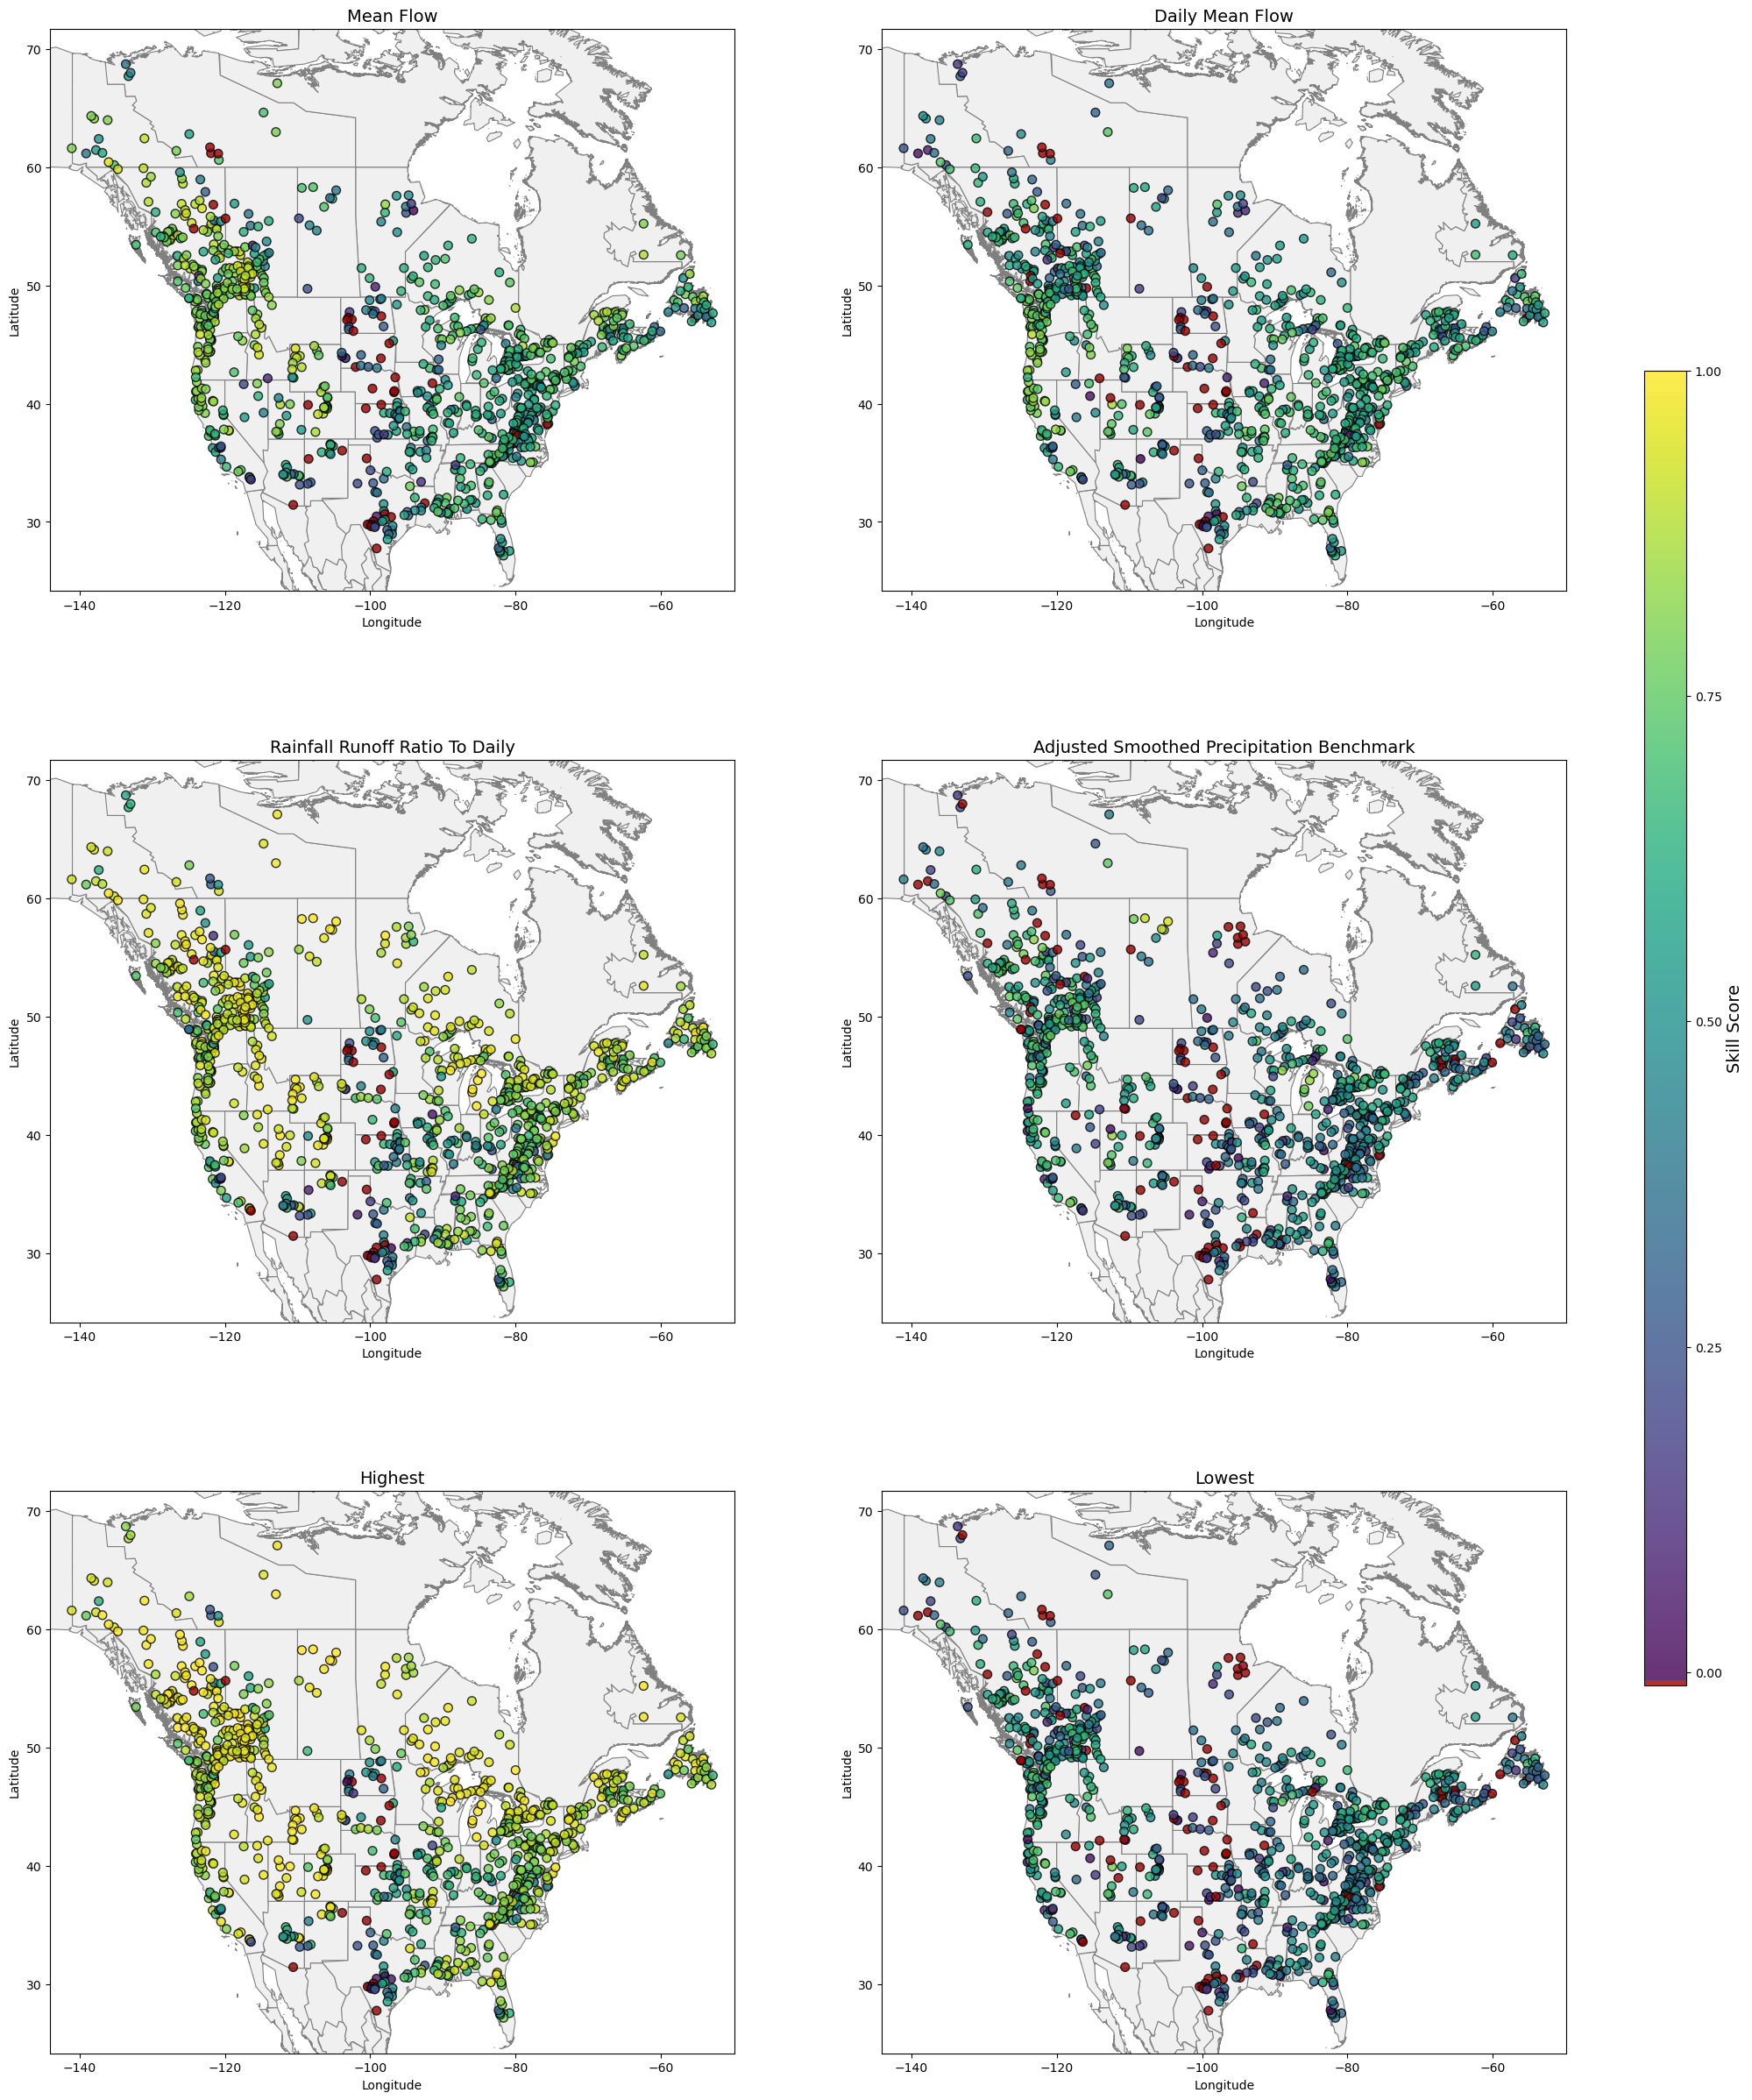

In [7]:
# --- Colormap setup
viridis = plt.cm.viridis
cmap_array = viridis(np.linspace(0, 1, 256))
neg_color = np.array([[0.6, 0, 0, 1]])  # dark red RGBA
cmap = ListedColormap(np.vstack([neg_color, cmap_array]))

# Grid layout
n_cols = 2
n_plots = len(plot_dfs)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12 * n_cols, 10 * n_rows)
)

axes = axes.flatten() if n_plots > 1 else [axes]

for ax, (benchmark, df_plot) in zip(axes, plot_dfs.items()):

    print(f'Plotting {benchmark}')
    # --- Format title
    title = benchmark[3:] if benchmark.startswith('bm_') else benchmark
    title = title.replace('_', ' ').title()
    
    # --- Find extent of points
    lon_min, lon_max = df_plot['longitude'].min() - 3, df_plot['longitude'].max() + 3
    lat_min, lat_max = df_plot['latitude'].min() - 3, df_plot['latitude'].max() + 3
    
    # --- Trim borders shapefile to the points extent
        # Filter borders by points extent
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= lon_max) &
        (gdf_borders.geometry.bounds.maxx >= lon_min) &
        (gdf_borders.geometry.bounds.miny <= lat_max) &
        (gdf_borders.geometry.bounds.maxy >= lat_min)
    ]

    
    # --- Plot the borders
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Scatter points
    colors = np.where(df_plot['skill_score'] < 0, -0.01, df_plot['skill_score'])
    sc = ax.scatter(
        df_plot['longitude'], df_plot['latitude'],
        c=colors,
        cmap=cmap,
        s=50,
        edgecolor='k',
        alpha=0.8,
        norm=Normalize(vmin=-0.01, vmax=1)
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Remove any empty axes
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Adjust layout
plt.subplots_adjust(hspace=0.3, wspace=0.1, right=0.88)

# Colorbar
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Skill Score', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

# --- Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.pdf', dpi=300)
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.png', dpi=300)

plt.show()


### Difference Between NSE and Lowest Benchmark

In [6]:
# Extract mean_flow rows
df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
    'catchment', 'latitude', 'longitude', 'skill_score'
]].rename(columns={'skill_score': 'mean_flow_score'})

# Extract lowest values from catchment_stats
df_low = catchment_stats[['catchment', 'lowest_value']]

# Merge
df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')

# Compute difference
df_diff['skill_diff'] = df_diff['mean_flow_score'] - df_diff['lowest_value']

In [7]:
df_diff

,catchment,latitude,longitude,mean_flow_score,lowest_value,skill_diff
0,CAN_01AD003,47.500671,-69.177691,0.850045,0.586148,0.263898
1,CAN_01AF007,47.321888,-67.719770,0.755864,0.446858,0.309006
2,CAN_01AJ003,46.199305,-67.920310,0.680604,0.352306,0.328298
3,CAN_01AJ004,46.515607,-67.880282,0.755933,0.536295,0.219638
4,CAN_01AJ010,46.312779,-67.312148,0.739400,0.479145,0.260255
...,...,...,...,...,...,...
955,USA_14306500,44.349780,-123.675199,0.876877,0.642455,0.234422
956,USA_14309500,42.830322,-123.743384,0.852943,0.638750,0.214193
957,USA_14316700,43.453012,-122.646785,0.839560,0.654714,0.184845
958,USA_14325000,42.792333,-124.027767,0.866241,0.622082,0.244158


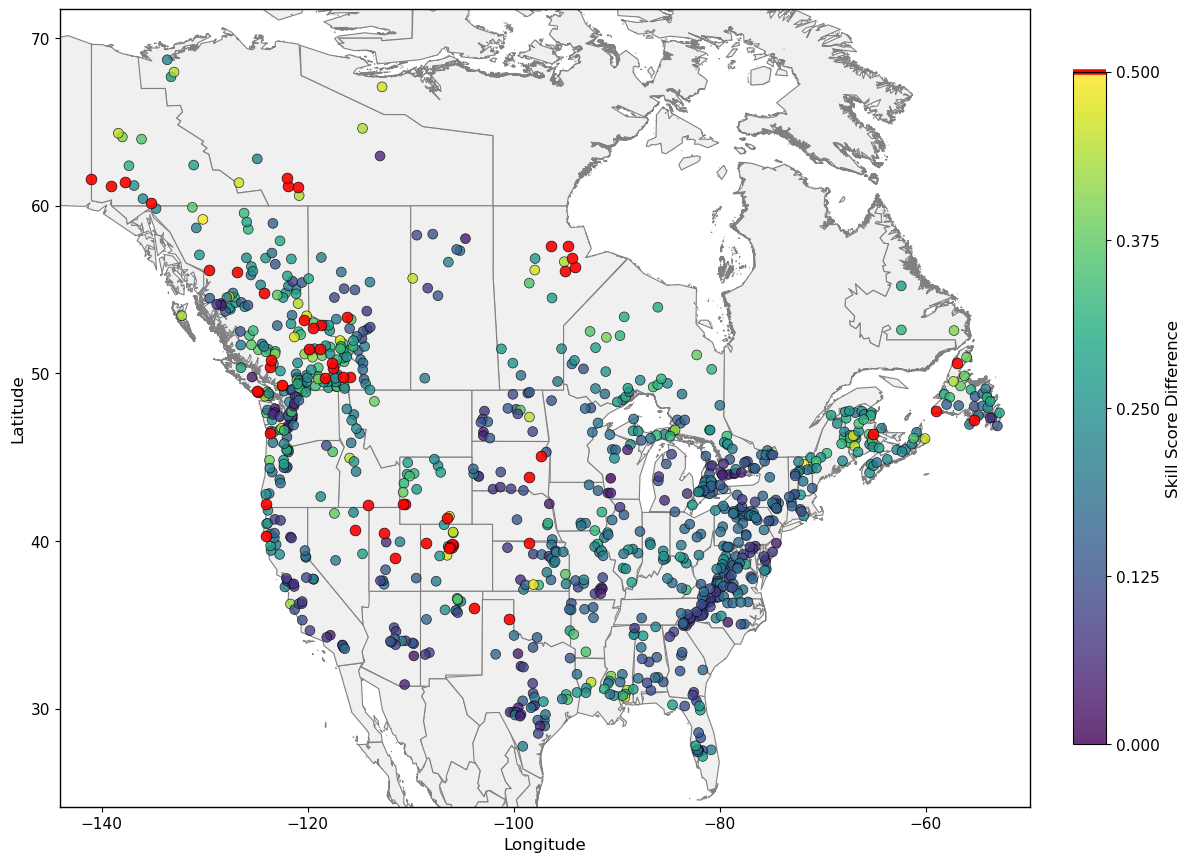

In [9]:
# --- Check if there's data
if df_diff.empty:
    print("⚠️ No overlapping catchments found between bm_mean_flow and lowest_value.")
else:
    # --- Trim extent with buffer (same method as subplot)
    lon_min, lon_max = df_diff['longitude'].min() - 3, df_diff['longitude'].max() + 3
    lat_min, lat_max = df_diff['latitude'].min() - 3, df_diff['latitude'].max() + 3
    
    # --- Filter borders shapefile to bbox
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= lon_max) &
        (gdf_borders.geometry.bounds.maxx >= lon_min) &
        (gdf_borders.geometry.bounds.miny <= lat_max) &
        (gdf_borders.geometry.bounds.maxy >= lat_min)
    ]
    
    # --- Square figure (matching reference dimensions)
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # --- Plot trimmed borders (matching reference style)
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Set extent
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # --- Scatter plot with colormap
    cmap = plt.cm.viridis
    vmin, vmax = 0, 0.5
    
    within_range = df_diff[df_diff['skill_diff'] <= vmax]
    above_range = df_diff[df_diff['skill_diff'] > vmax]
    
    sc = ax.scatter(
        within_range['longitude'], within_range['latitude'],
        c=within_range['skill_diff'],
        cmap=cmap,
        norm=Normalize(vmin=vmin, vmax=vmax),
        s=50,
        edgecolor='k',
        linewidths=0.5,
        alpha=0.8,
        zorder=3
    )
    
    if not above_range.empty:
        ax.scatter(
            above_range['longitude'], above_range['latitude'],
            color='red',
            s=60,
            edgecolor='k',
            linewidths=0.5,
            alpha=0.9,
            zorder=3
        )
    
    # --- Format axes (matching reference style)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # No gridlines for cleaner look
    ax.grid(False)
    
    # Box around plot (matching reference)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')
    
    # --- Add colorbar (positioned like reference, no title on top)
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
    cbar.set_label('Skill Score Difference', fontsize=12)
    cbar.set_ticks([0, 0.125, 0.25, 0.375, 0.5])
    cbar.ax.tick_params(labelsize=11)
    
    # Red indicator at top of colorbar
    if not above_range.empty:
        cbar.ax.plot([0, 1], [1, 1], color='red', linewidth=4, 
                     transform=cbar.ax.transAxes, clip_on=False, solid_capstyle='butt')
    
    plt.tight_layout()
    
    # --- Save + show
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_diff_meanflow_lowest.png',
                dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_diff_meanflow_lowest.pdf',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

### CDF

In [12]:
# Prepare data for plotting
cdf_dfs = {}  # initialize dictionary
for benchmark in cdf_plots:
    if benchmark == 'highest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']].rename(columns={'highest_value':'skill_score'})
    elif benchmark == 'lowest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']].rename(columns={'lowest_value':'skill_score'})
    else:
        cdf_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][['catchment','latitude','longitude','skill_score']]


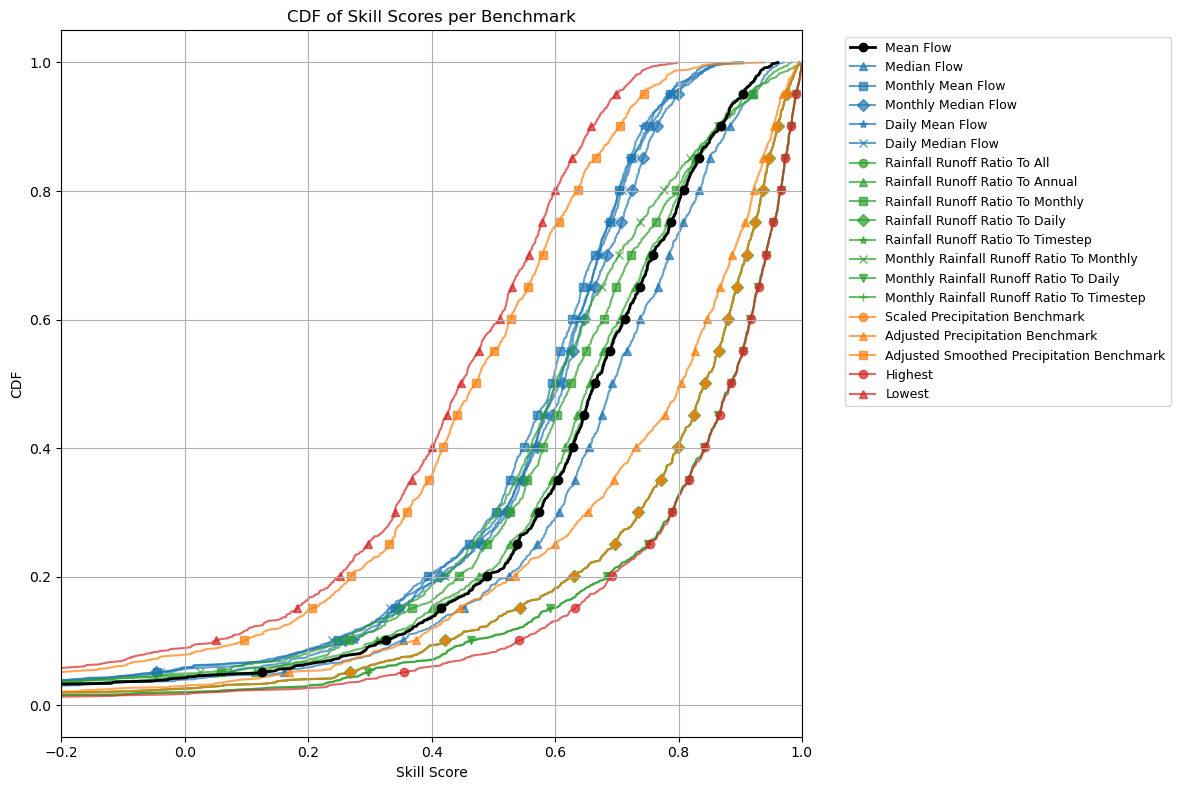

In [13]:
# Define categories
categories = {
    'Flow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow"
    ],
    'Rainfall': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep"
    ],
    'Adjusted': [
        "bm_scaled_precipitation_benchmark",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark"
    ],
    'Ensemble': ['highest', 'lowest']
}

# Assign colors for categories
colors = {
    'Flow': 'tab:blue',
    'Rainfall': 'tab:green',
    'Adjusted': 'tab:orange',
    'Ensemble': 'tab:red'
}
# Define a set of markers to cycle through
markers = ['o', '^', 's', 'D', '*', 'x', 'v', '+', 'p', 'h']

# Helper function to clean benchmark names
def clean_label(name):
    name = name.replace("bm_", "")          # remove 'bm_' prefix
    name = name.replace("_", " ")           # replace underscores with spaces
    name = name.title()                     # capitalize each word
    return name

plt.figure(figsize=(12, 8))

for cat, benchmarks in categories.items():
    for i, benchmark in enumerate(benchmarks):
        if benchmark in cdf_dfs:
            scores = cdf_dfs[benchmark]['skill_score'].dropna().sort_values()
            cdf = np.arange(1, len(scores)+1) / len(scores)
            
            # Cycle markers
            marker = markers[i % len(markers)]
            
            # Highlight bm_mean_flow
            if benchmark == 'bm_mean_flow':
                lw = 2
                alpha = 1.0
                linestyle = '-'
                zorder = 10
                color = 'black'
            else:
                lw = 1.5
                alpha = 0.7
                linestyle = '-'
                zorder = 1
                color = colors[cat]

            # Cleaned label
            label = clean_label(benchmark) if benchmark != 'bm_mean_flow' else "Mean Flow"

            plt.plot(
                scores, cdf,
                label=label,
                color=color,
                marker=marker,
                markevery=max(1, len(scores)//20),
                alpha=alpha,
                linewidth=lw,
                linestyle=linestyle,
                zorder=zorder
            )

plt.xlabel('Skill Score')
plt.ylabel('CDF')
plt.title('CDF of Skill Scores per Benchmark')
plt.xlim(-0.2, 1)
plt.grid(True)

# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.pdf', dpi=300, bbox_inches='tight')
plt.show()



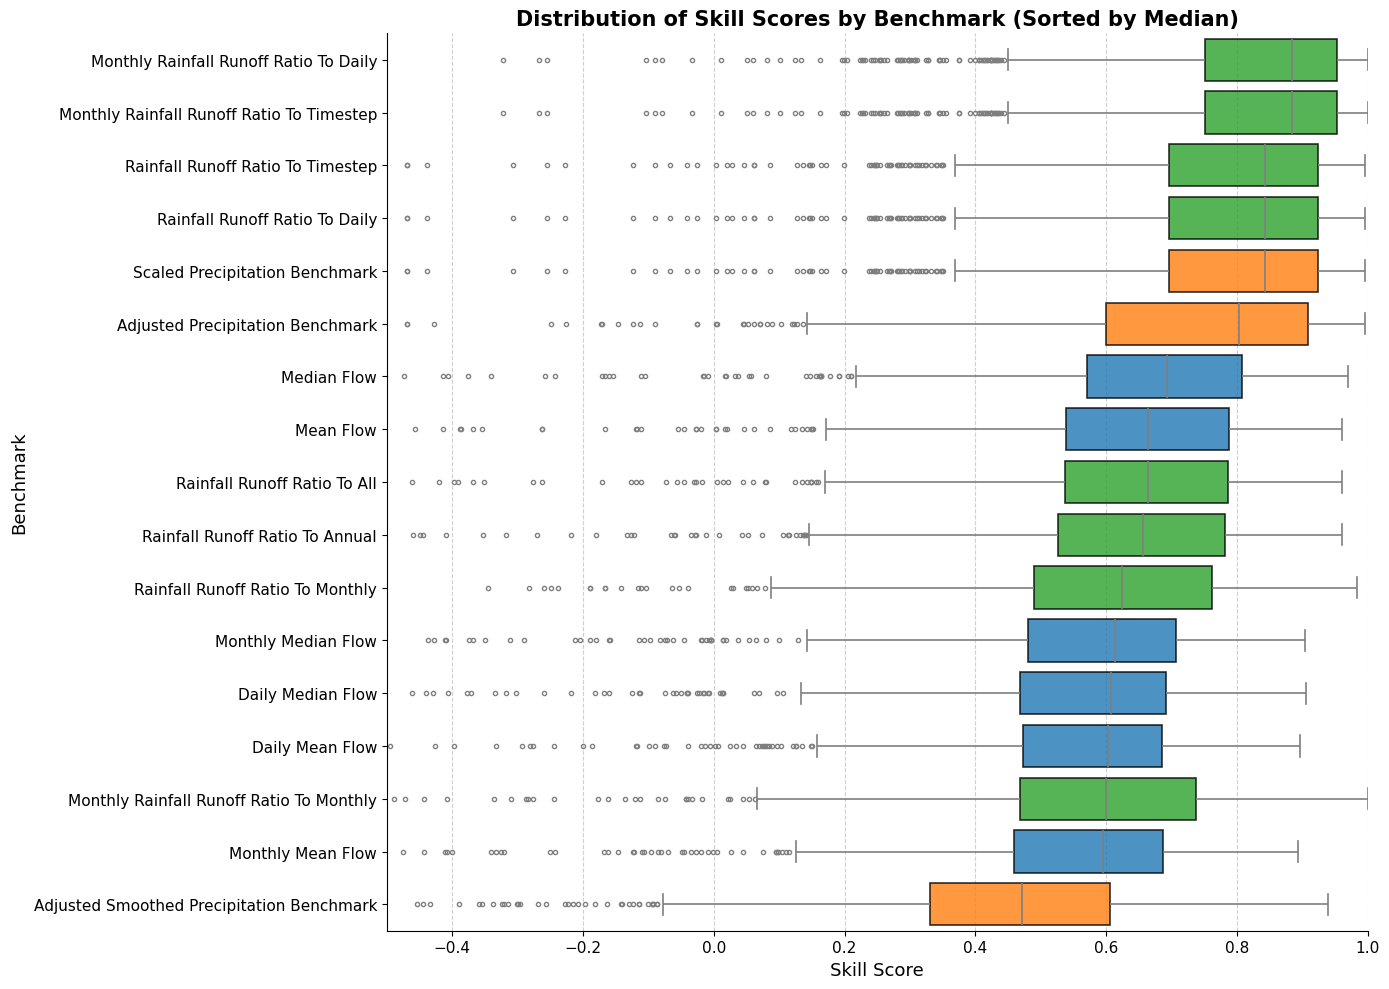

In [14]:
# Define a soft, categorical color palette
palette = {
    'Flow': '#1f77b4',      # blue
    'Rainfall': '#2ca02c',  # green
    'Adjusted': '#ff7f0e',  # orange
    'Ensemble': '#d62728'   # red
}

df_period = df_period.copy()

# === Compute median and sort benchmarks (descending) ===
median_order = (
    df_period.groupby('benchmark', observed=True)['skill_score']
    .median()
    .sort_values(ascending=False)
)

# Create benchmark order and corresponding colors (sorted)
benchmark_order = []
benchmark_colors = []
for b in median_order.index:
    for cat, benchmarks in categories.items():
        if b in benchmarks and b in df_period['benchmark'].unique():
            benchmark_order.append(b)
            benchmark_colors.append(palette[cat])
            break

# Clean labels
def clean_label(name):
    name = name.replace("bm_", "")
    name = name.replace("_", " ")
    return name.title()

cleaned_labels = [clean_label(b) for b in benchmark_order]

# Ensure categorical order
df_period['benchmark'] = pd.Categorical(
    df_period['benchmark'],
    categories=benchmark_order,
    ordered=True
)

# === PLOT ===
plt.figure(figsize=(14, 10))

ax = sns.boxplot(
    data=df_period,
    y='benchmark',
    x='skill_score',
    fliersize=3,
    linewidth=1.2,
    color='lightgrey'
)

# Color boxes manually
for patch, color in zip(ax.patches, benchmark_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('k')
    patch.set_alpha(0.8)

plt.yticks(ticks=range(len(benchmark_order)), labels=cleaned_labels, fontsize=11)
plt.xticks(fontsize=11)
plt.xlabel('Skill Score', fontsize=13)
plt.ylabel('Benchmark', fontsize=13)
plt.title('Distribution of Skill Scores by Benchmark (Sorted by Median)', fontsize=15, weight='bold')

ax.grid(axis='x', linestyle='--', alpha=0.6, linewidth=0.8)
ax.set_xlim(-0.5, 1)
sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()

plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_pub_sorted_by_median.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_pub_sorted_by_median.pdf', dpi=300, bbox_inches='tight')

plt.show()


### Statistics

In [15]:
# 1. Per-benchmark stats
stats_df = pd.DataFrame(columns=['benchmark','mean','median','std','iqr','min','max'])
for benchmark, df in cdf_dfs.items():
    scores = df['skill_score'].dropna()
    stats_df = pd.concat([
        stats_df,
        pd.DataFrame([{
            'benchmark': benchmark,
            'mean': scores.mean(),
            'median': scores.median(),
            'std': scores.std(),
            'iqr': scores.quantile(0.75) - scores.quantile(0.25),
            'min': scores.min(),
            'max': scores.max()
        }])
    ], ignore_index=True)

# 2. Per-group stats
group_stats = pd.DataFrame(columns=['group','mean','median','std','iqr','min','max'])
for group, benchmarks in categories.items():
    # collect all scores in this group
    all_scores = pd.concat([plot_dfs[b]['skill_score'].dropna() for b in benchmarks if b in plot_dfs])
    if len(all_scores) > 0:
        group_stats = pd.concat([
            group_stats,
            pd.DataFrame([{
                'group': group,
                'mean': all_scores.mean(),
                'median': all_scores.median(),
                'std': all_scores.std(),
                'iqr': all_scores.quantile(0.75) - all_scores.quantile(0.25),
                'min': all_scores.min(),
                'max': all_scores.max()
            }])
        ], ignore_index=True)



/tmp/ipykernel_134847/3874675650.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([
/tmp/ipykernel_134847/3874675650.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_stats = pd.concat([


In [16]:
stats_df

,benchmark,mean,median,std,iqr,min,max
0,bm_mean_flow,0.452965,0.664300,3.043094,0.249729,-88.797707,0.961082
1,bm_median_flow,0.479901,0.692505,2.988332,0.236877,-87.172961,0.970264
2,bm_monthly_mean_flow,0.343447,0.594881,3.152202,0.227739,-90.065053,0.893971
3,bm_monthly_median_flow,0.365483,0.613387,3.045554,0.227089,-87.172961,0.904466
4,bm_daily_mean_flow,0.363357,0.603268,3.065488,0.213122,-82.654151,0.896936
5,bm_daily_median_flow,0.343886,0.607113,3.168835,0.223812,-87.335818,0.904943
6,bm_rainfall_runoff_ratio_to_all,0.450238,0.663874,3.042884,0.248112,-88.771050,0.961041
7,bm_rainfall_runoff_ratio_to_annual,0.441153,0.655875,3.048120,0.255141,-88.812683,0.960587
8,bm_rainfall_runoff_ratio_to_monthly,0.408970,0.624872,3.181394,0.273376,-92.302980,0.983339
9,bm_rainfall_runoff_ratio_to_daily,0.611135,0.843089,3.202841,0.227817,-96.020170,0.995085


In [17]:
group_stats

,group,mean,median,std,iqr,min,max
0,Flow,0.408161,0.632238,3.053844,0.217592,-88.797707,0.961082
1,Rainfall,0.611135,0.843089,3.202841,0.227817,-96.020170,0.995085
2,Adjusted,0.220305,0.471109,3.635093,0.274595,-105.817872,0.938371
3,Ensemble,0.423948,0.628641,3.326617,0.467979,-105.817872,0.999987


In [18]:
# Ensure highest and lowest exist
if 'highest' in plot_dfs and 'lowest' in plot_dfs:
    # Get scores
    high_scores = plot_dfs['highest']['skill_score'].dropna().sort_values()
    low_scores = plot_dfs['lowest']['skill_score'].dropna().sort_values()
    
    # Compute CDFs
    high_cdf = np.arange(1, len(high_scores)+1) / len(high_scores)
    low_cdf = np.arange(1, len(low_scores)+1) / len(low_scores)
    
    # Find CDF value at skill_score = 0
    # Use searchsorted to find the index where score >= 0
    idx_high = np.searchsorted(high_scores, 0)
    idx_low = np.searchsorted(low_scores, 0)
    
    # Probability that score <= 0
    prob_high = high_cdf[idx_high] if idx_high < len(high_cdf) else 1.0
    prob_low = low_cdf[idx_low] if idx_low < len(low_cdf) else 1.0
    
    diff_prob = prob_high - prob_low
    
    print(f"Probability (skill <= 0) for 'highest': {prob_high:.2f}")
    print(f"Probability (skill <= 0) for 'lowest': {prob_low:.2f}")
    print(f"Difference in probability: {diff_prob:.2f}")
else:
    print("Highest or lowest benchmark missing in plot_dfs")

Probability (skill <= 0) for 'highest': 0.02
Probability (skill <= 0) for 'lowest': 0.09
Difference in probability: -0.07


In [19]:
df_period

,catchment,latitude,longitude,period,benchmark,skill_score
19,CAN_01AD003,47.500671,-69.177691,validation,bm_mean_flow,0.850045
20,CAN_01AD003,47.500671,-69.177691,validation,bm_median_flow,0.868807
21,CAN_01AD003,47.500671,-69.177691,validation,NaN,NaN
22,CAN_01AD003,47.500671,-69.177691,validation,NaN,NaN
23,CAN_01AD003,47.500671,-69.177691,validation,bm_monthly_mean_flow,0.736323
...,...,...,...,...,...,...
54696,USA_14400000,42.233184,-124.004923,validation,bm_monthly_rainfall_runoff_ratio_to_daily,0.744442
54697,USA_14400000,42.233184,-124.004923,validation,bm_monthly_rainfall_runoff_ratio_to_timestep,0.744442
54698,USA_14400000,42.233184,-124.004923,validation,bm_scaled_precipitation_benchmark,0.733808
54699,USA_14400000,42.233184,-124.004923,validation,bm_adjusted_precipitation_benchmark,0.618392


In [20]:

# Filter to remove NaN skill scores
df_valid = df_period.dropna(subset=['skill_score']).copy()

# Find the benchmark with the minimum skill score per catchment
lowest_per_catchment = df_valid.loc[df_valid.groupby('catchment')['skill_score'].idxmin()]

# Count how many times each benchmark is the lowest
lowest_counts = lowest_per_catchment['benchmark'].value_counts().sort_values(ascending=False)

# Convert to DataFrame
lowest_counts_df = lowest_counts.reset_index()
lowest_counts_df.columns = ['benchmark', 'count']

# Apply formatting: remove 'bm_' prefix, replace '_' with space, capitalize words
lowest_counts_df['benchmark'] = (
    lowest_counts_df['benchmark']
    .str.replace(r'^bm_', '', regex=True)  # remove 'bm_' prefix
    .str.replace('_', ' ')                  # replace underscores with spaces
    .str.title()                            # capitalize first letter of each word
)

In [21]:
lowest_counts_df

,benchmark,count
0,Adjusted Smoothed Precipitation Benchmark,668
1,Daily Mean Flow,103
2,Monthly Rainfall Runoff Ratio To Monthly,57
3,Monthly Mean Flow,34
4,Adjusted Precipitation Benchmark,22
5,Monthly Median Flow,20
6,Daily Median Flow,17
7,Rainfall Runoff Ratio To Monthly,16
8,Monthly Rainfall Runoff Ratio To Daily,9
9,Rainfall Runoff Ratio To Daily,7
